In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # noqa
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deepwaters  # noqa
from deepwaters.utils import ROOT_DIR
from deepwaters.visualization import plot_basinwise_map
from deepwaters.regions import basins

In [ ]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/si"

# Register dask progress bar
ProgressBar(minimum=5).register()

In [3]:
ds = xr.open_zarr(
    ROOT_DIR / "models/predictions/global/ensemble_alltrain_10folds_combined.zarr"
)
ds

<xarray.Dataset> Size: 4GB
Dimensions:                                    (lat: 360, lon: 720, time: 973)
Coordinates:
  * lat                                        (lat) float32 1kB 89.75 ... -8...
  * lon                                        (lon) float32 3kB -179.8 ... 1...
  * time                                       (time) datetime64[ns] 8kB 1940...
Data variables:
    pred_ensemble_alltrain_gap_lnll_latest     (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest   (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_gap_lnll_latest    (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_nogap_lnll_latest  (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>

In [4]:
pred_renamer = {
    "pred_ensemble_alltrain_gap_lnll_latest": "gap",
    "pred_ensemble_alltrain_nogap_lnll_latest": "nogap",
}
sigma_renamer = {
    "sigma_ensemble_alltrain_gap_lnll_latest": "gap",
    "sigma_ensemble_alltrain_nogap_lnll_latest": "nogap",
}
models_verbose = {
    "gap": "Ours w/ WGHM",
    "nogap": "Ours w/o WGHM",
}
models = models_verbose.keys()

In [5]:
sigmas = ds[sigma_renamer.keys()].rename(sigma_renamer)
preds = ds[pred_renamer.keys()].rename(pred_renamer)

## Standard deviation map plots

### Grid-wise

In [6]:
sigma_means = sigmas.mean("time").compute()
da_sigma_means = sigma_means.to_dataarray("model")

In [7]:
plot_kwargs = dict(
    cmap="mako",
    coastlines=True,
    gridlines=True,
    figsize=(6, 3.5),
    rasterized=True,
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.06),
)
basinlines_kwargs = dict(
    edgecolor="black",
    linewidth=0.5,
    facecolor="None",
    rasterized=True,
)

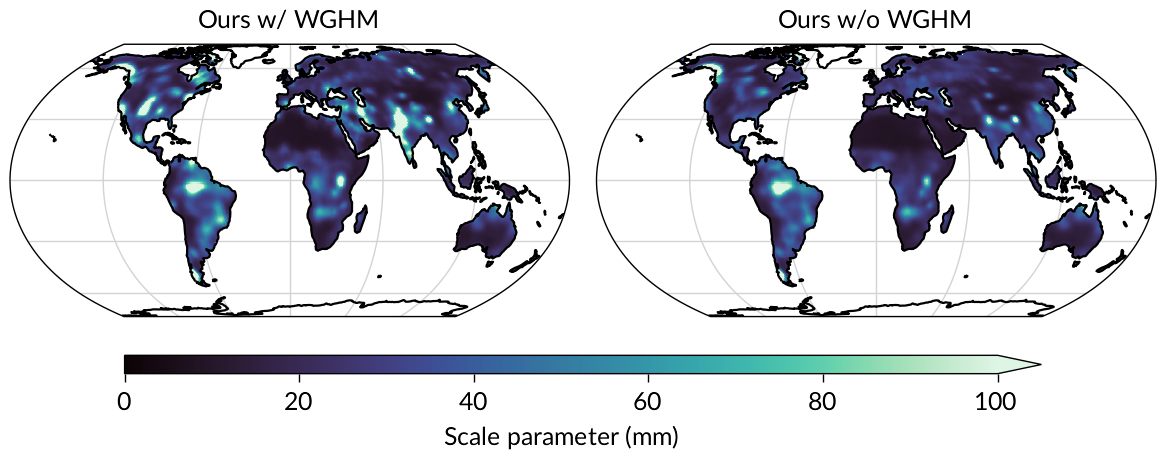

In [8]:
plot_kwargs["cbar_kwargs"]["label"] = "Scale parameter (mm)"

p = da_sigma_means.dw.projplot(col="model", vmin=0, vmax=100, **plot_kwargs)

for ax, model in zip(p.axs.flat, models):
    ax.set_title(models_verbose[model])

p.fig.savefig(FIGURE_DIR / "uncertainty_map_gridwise.pdf", backend="pgf")

### Basin-wise

In [9]:
sigmas_basin = (
    sigmas.chunk(time=1, lat=-1, lon=-1)
    .dw.select_basins(top=72)
    .dw.weight_lat()
    .mean(["lat", "lon"])
    .compute()
)
sigma_basin_means = sigmas_basin.mean("time")
da_sigma_basin_means = sigma_basin_means.to_dataarray("model")

[########################################] | 100% Completed | 75.45 s


In [10]:
print(f"{da_sigma_basin_means.max() = :.2f}")

da_sigma_basin_means.max() = 82.53


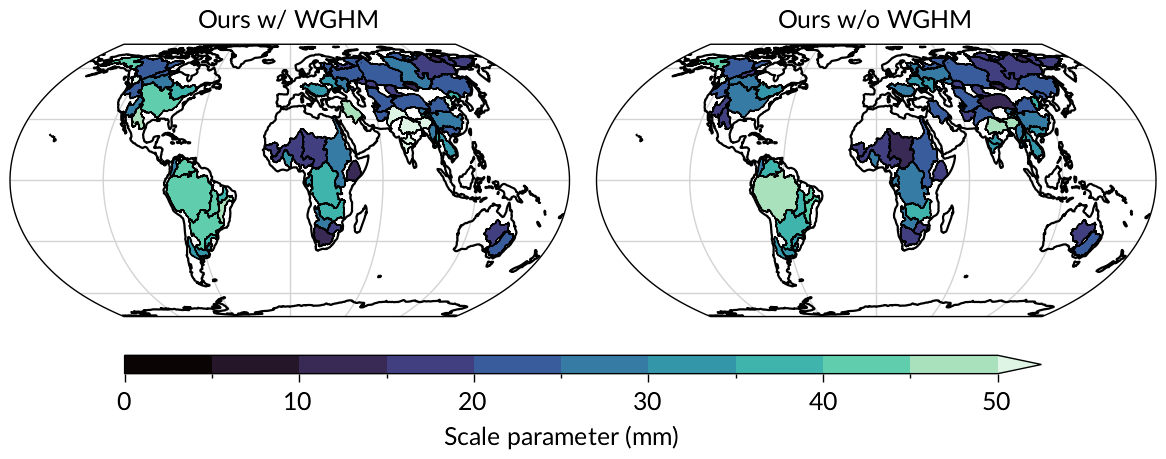

In [11]:
plot_kwargs["cbar_kwargs"]["label"] = "Scale parameter (mm)"

p = plot_basinwise_map(
    da_sigma_basin_means,
    spatial_obj=da_sigma_means,
    col="model",
    vmin=0,
    vmax=50,
    levels=11,
    **plot_kwargs,
)
# Plot basin shapes
basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, models):
    ax.set_title(models_verbose[model])
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(FIGURE_DIR / "uncertainty_map_basinwise.pdf", backend="pgf")

### Global confidence interval time series

In [12]:
mu_global = (
    preds.dw.weight_lat()
    .mean(["lat", "lon"], keep_attrs=True)
    .groupby("time.year")
    .mean()
    .compute()
)

ubound_global = (
    (preds + sigmas)
    .dw.weight_lat()
    .mean(["lat", "lon"], keep_attrs=True)
    .groupby("time.year")
    .mean()
    .compute()
)
lbound_global = (
    (preds - sigmas)
    .dw.weight_lat()
    .mean(["lat", "lon"], keep_attrs=True)
    .groupby("time.year")
    .mean()
    .compute()
)

[########################################] | 100% Completed | 20.03 s


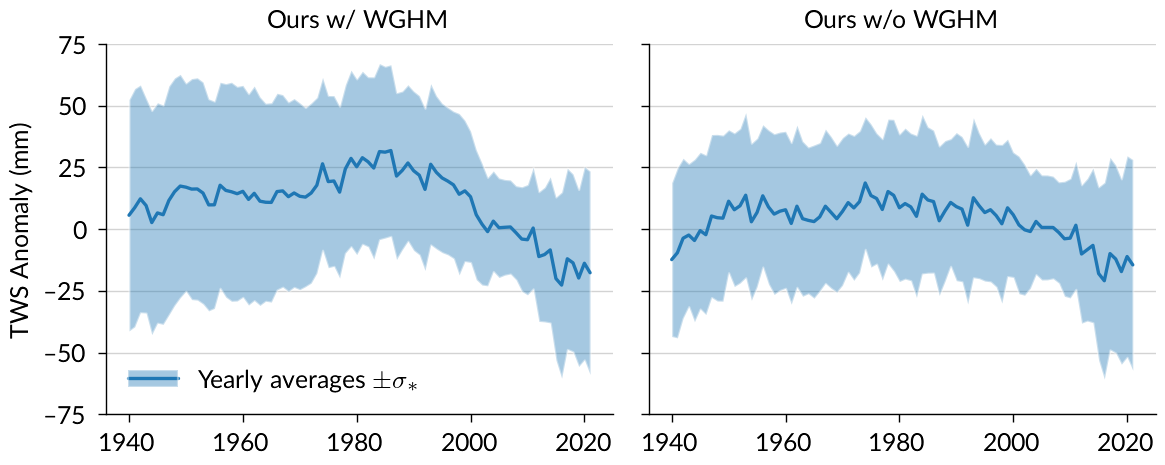

In [41]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 2.5))

for ax, model in zip(axs.flat, models):
    (mean,) = ax.plot(mu_global.year, mu_global[model])
    ci = ax.fill_between(
        x=mu_global.year,
        y1=lbound_global[model],
        y2=ubound_global[model],
        alpha=0.4,
        label=r"Yearly average",
    )
    ax.set(
        xlabel=None,
        ylabel="TWS Anomaly (mm)",
        ylim=(-75, 75),
        title=models_verbose[model],
    )
    ax.label_outer()
    ax.yaxis.grid(True)
axs.flat[0].legend(
    [(mean, ci)],
    [r"Yearly averages $\pm \sigma_*$"],
    loc="lower left",
)

fig.savefig(FIGURE_DIR / "uncertainty_timeseries_1sigma.pdf", backend="pgf")

In [14]:
# Not used anymore as mixed variance is assumed to be Gaussian
def laplace_ci(
    mean: xr.DataArray, scale: xr.DataArray, confidence: float
) -> tuple[xr.DataArray, xr.DataArray]:
    # Calc upper and lower probabilities
    lprob = (1 - confidence) / 2
    uprob = 1 - lprob

    # Calc percentiles
    lquantile = mean + scale * np.log(2 * lprob)
    uquantile = mean - scale * np.log(2 - 2 * uprob)

    return lquantile, uquantile

In [15]:
cmap = sns.color_palette()

In [16]:
# Z-scores
z_70 = 1.036
z_80 = 1.282
z_90 = 1.645

ubound_70 = preds + z_70 * sigmas
lbound_70 = preds - z_70 * sigmas
ubound_90 = preds + z_90 * sigmas
lbound_90 = preds - z_90 * sigmas

ubound_70_global = (
    ubound_70.dw.weight_lat()
    .mean(["lat", "lon"], keep_attrs=True)
    .groupby("time.year")
    .mean()
    .compute()
)
lbound_70_global = (
    lbound_70.dw.weight_lat()
    .mean(["lat", "lon"], keep_attrs=True)
    .groupby("time.year")
    .mean()
    .compute()
)
ubound_90_global = (
    ubound_90.dw.weight_lat()
    .mean(["lat", "lon"], keep_attrs=True)
    .groupby("time.year")
    .mean()
    .compute()
)
lbound_90_global = (
    lbound_90.dw.weight_lat()
    .mean(["lat", "lon"], keep_attrs=True)
    .groupby("time.year")
    .mean()
    .compute()
)

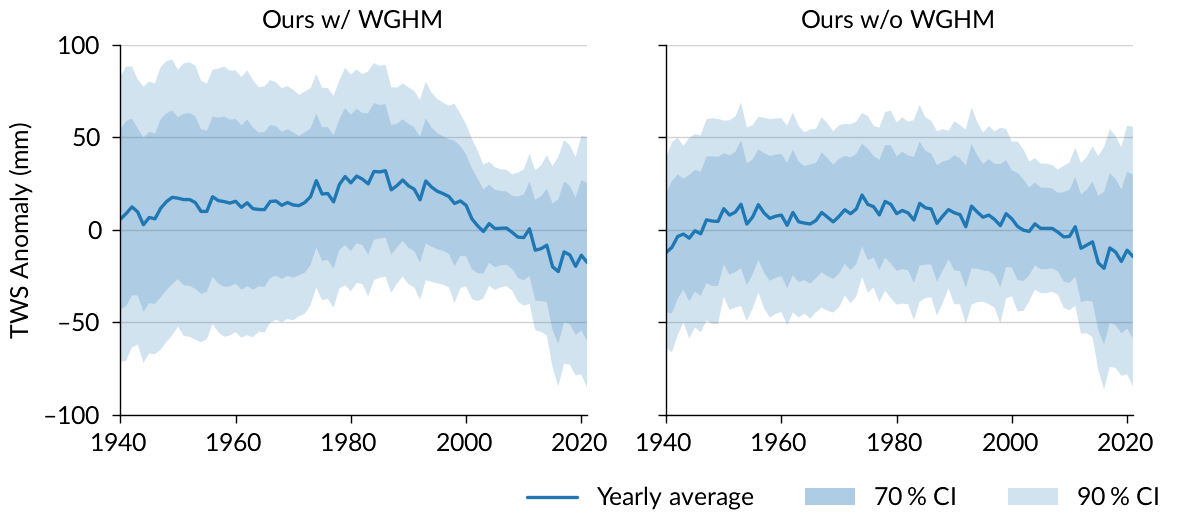

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 2.5), sharex=True, sharey=True)

for ax, model in zip(axs.flat, models):
    (mean,) = ax.plot(mu_global.year, mu_global[model])
    ci_90 = ax.fill_between(
        x=mu_global.year,
        y1=lbound_90_global[model],
        y2=ubound_90_global[model],
        alpha=0.2,
        color="none",
        facecolor=cmap[0],
    )
    ci_70 = ax.fill_between(
        x=mu_global.year,
        y1=lbound_70_global[model],
        y2=ubound_70_global[model],
        alpha=0.2,
        color="none",
        facecolor=cmap[0],
    )
    ax.set(
        xlabel=None,
        ylabel="TWS Anomaly (mm)",
        xlim=(1940, 2021),
        ylim=(-100, 100),
        title=models_verbose[model],
    )
    ax.yaxis.grid(True)
    ax.label_outer()

fig.legend(
    [mean, (ci_70, ci_90), ci_90],
    ["Yearly average", r"\qty{70}{\percent} CI", r"\qty{90}{\percent} CI"],
    loc="lower right",
    bbox_to_anchor=(1.0, -0.1),
    title=None,
    frameon=False,
    ncols=3,
)

fig.savefig(FIGURE_DIR / "uncertainty_timeseries_ci.pdf", backend="pgf")

## Plot aleatoric and epistemic uncertainty

In [19]:
# Import individual predictions
pred_dir = ROOT_DIR / "models/predictions/global"

nogap_members = xr.open_zarr(pred_dir / "ensemble_alltrain_nogap_lnll.zarr")
gap_members = xr.open_zarr(pred_dir / "ensemble_alltrain_gap_lnll.zarr")

In [20]:
nogap_scale_names = [
    name for name in nogap_members.data_vars if name.split("_")[0] == "uncertainty"
]
gap_scale_names = [
    name for name in gap_members.data_vars if name.split("_")[0] == "uncertainty"
]
member_names = {"nogap": nogap_scale_names, "gap": gap_scale_names}

In [21]:
print(f"{nogap_scale_names = }")
print(f"{gap_scale_names = }")

nogap_scale_names = ['uncertainty_1rlcdr99_latest', 'uncertainty_4esg2us0_latest', 'uncertainty_bt2df0dm_latest', 'uncertainty_kkcrk8fc_latest', 'uncertainty_xbjfq8kp_latest']
gap_scale_names = ['uncertainty_0nh2f50x_latest', 'uncertainty_6qvavmpi_latest', 'uncertainty_i5lqyzdd_latest', 'uncertainty_n1oe6sit_latest', 'uncertainty_s3tvy3ew_latest']


In [22]:
member_scales = xr.merge(
    [nogap_members[nogap_scale_names], gap_members[gap_scale_names]]
)

### Plot scale parameters

In [23]:
# Take the global mean of the individual models
member_scales_global = (
    member_scales.dw.weight_lat()
    .mean(["lat", "lon"])
    .groupby("time.year")
    .mean()
    .compute()
)
# Take the global mean of the mixed distribution
sigmas_global = (
    sigmas.dw.weight_lat().mean(["lat", "lon"]).groupby("time.year").mean().compute()
)

[########################################] | 100% Completed | 5.04 s


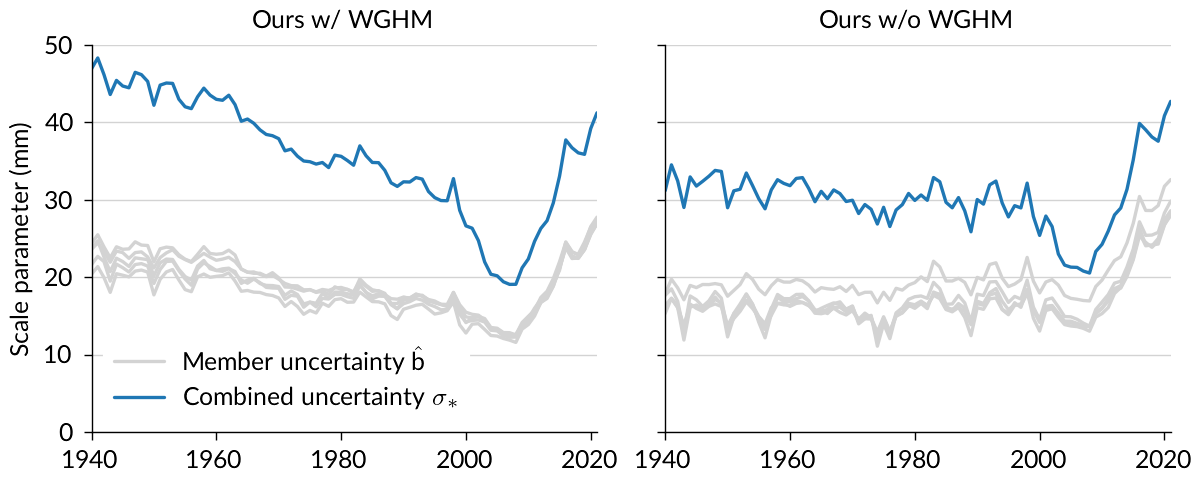

In [37]:
fig, axs = plt.subplots(
    ncols=2, figsize=(6, 2.4), sharex=True, sharey=True, layout="constrained"
)

for ax, model in zip(axs, models):
    # Print uncertainties (scale parameters) of individual models
    for member_name in member_names[model]:
        (line_members,) = member_scales_global[member_name].plot(
            ax=ax, color="lightgray"
        )
    # Print combined uncertainty (standard deviation)
    (line_combined,) = sigmas_global[model].plot(ax=ax)
    ax.set(
        xlabel=None,
        ylabel="Scale parameter (mm)",
        xlim=(1940, 2021),
        ylim=(0, 50),
        title=models_verbose[model],
    )
    ax.yaxis.grid(True)
    ax.label_outer()

axs[0].legend(
    [line_members, line_combined],
    [
        r"Member uncertainty $\hat b$",
        r"Combined uncertainty $\sigma_*$",
    ],
    loc="lower left",
    frameon=True,
)
fig.savefig(FIGURE_DIR / "uncertainty_scale_members.pdf", backend="pgf")

### Plot variances parameters

In [38]:
# Var = 2b²
member_variances = 2 * member_scales**2
# Var = σ²
comb_variances = sigmas**2

In [39]:
# Take the global mean of the individual models
member_variances_global = (
    member_variances.dw.weight_lat()
    .mean(["lat", "lon"])
    .groupby("time.year")
    .mean()
    .compute()
)
# Take the global mean of the mixed distribution
comb_variances_global = (
    comb_variances.dw.weight_lat()
    .mean(["lat", "lon"])
    .groupby("time.year")
    .mean()
    .compute()
)

[########################################] | 100% Completed | 8.11 s


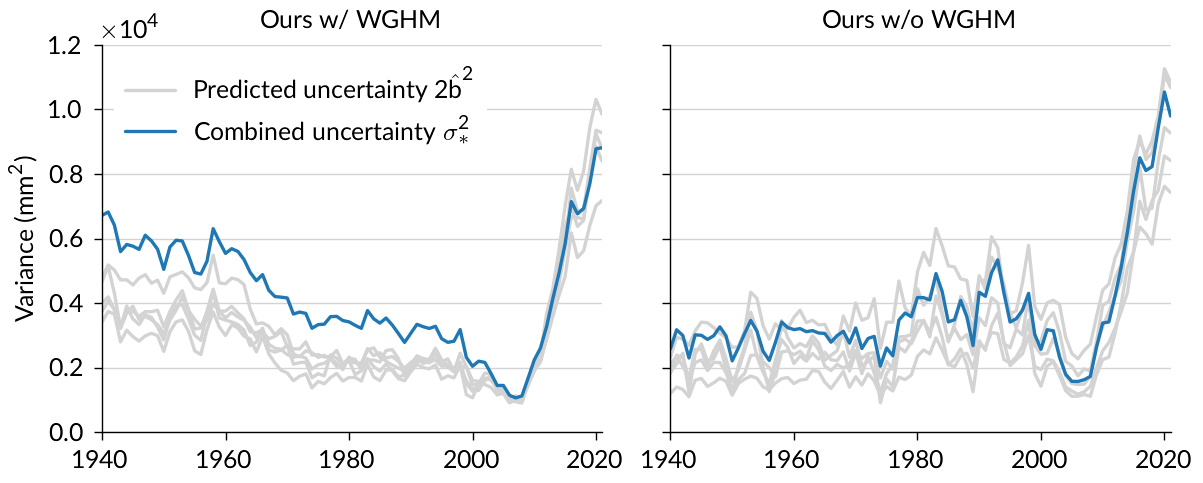

In [40]:
fig, axs = plt.subplots(
    ncols=2, figsize=(6, 2.4), sharex=True, sharey=True, layout="constrained"
)

for ax, model in zip(axs, models):
    # Print uncertainties (scale parameters) of individual models
    for member_name in member_names[model]:
        (line_members,) = member_variances_global[member_name].plot(
            ax=ax, color="lightgray"
        )
    # Print combined uncertainty (standard deviation)
    (line_combined,) = comb_variances_global[model].plot(ax=ax)
    ax.set(
        xlabel=None,
        ylabel=r"Variance (\unit{\mm\squared})",
        xlim=(1940, 2021),
        ylim=(0, 12000),
        title=models_verbose[model],
    )
    ax.yaxis.grid(True)
    ax.ticklabel_format(axis="y", scilimits=(0, 0), useMathText=True)
    ax.label_outer()

axs[0].legend(
    [line_members, line_combined],
    [
        r"Predicted uncertainty $2\hat b^2$",
        r"Combined uncertainty $\sigma_*^2$",
    ],
    loc="upper left",
    frameon=True,
)
fig.savefig(FIGURE_DIR / "uncertainty_variance_members.pdf", backend="pgf")